## 套件安裝

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab/資料分析期末') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['data',
 'models',
 'preprocessed_output',
 '過往東東',
 'share_data',
 'model選特徵0601.ipynb',
 'LSTM_torch_duration.ipynb',
 'LSTM_GRU_torch_ensemble.ipynb',
 'submit.csv',
 'XGBoost.ipynb',
 'test其餘特徵處理.ipynb',
 'train的其餘特徵.ipynb',
 'LSTM_CV.ipynb']

In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# always needed
import math, os, random, csv
import pandas as pd
import numpy as np

# log and save
import json, logging, pickle, sys, shutil, copy
# torch
import torch
import torch.nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU
import torchvision
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchinfo import summary
from sklearn.model_selection import KFold


# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
import seaborn as sns

# others
import matplotlib.pyplot as plt
from PIL import Image

# sklearn
from sklearn import preprocessing

# statistics
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statistics

# seeds
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [6]:
def show_loss(train_loss, valid_loss):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(train_loss, color='blue', linewidth=2)
    axes[0].set_title('Training Loss', fontsize=16)
    axes[0].set_xlabel('iteration', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].grid(True)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # Plot validation loss
    axes[1].plot(valid_loss, color='red', linewidth=2)
    axes[1].set_title('Validation Loss', fontsize=16)
    axes[1].set_xlabel('iteration', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].grid(True)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [7]:
config = {
    'seed': 507,
    'valid_ratio': 0.2,
    'test_ratio': 0.1,   
    'n_epochs': 25,             
    'batch_size': 32, 
    'learning_rate': 6e-4,              
    'early_stop': 10,  
    'input_size': 5
}

## 加載資料

In [8]:
class TrainDataset(Dataset):
    # data loading
    def __init__(self, file_name_X, file_name_Y):
        #X = pd.read_csv(file_name_X).drop(columns=['user_id']).to_numpy()
        X = np.load(file_name_X)
        X = X.reshape(X.shape[0], -1, config['input_size']) #變成每七天一個vector feature input_size=28, seq_len=37
        Y = np.load(file_name_Y)
        self.x = torch.from_numpy(X).to(torch.float32)
        self.y = torch.from_numpy(Y).to(torch.float32)
        self.n_samples = self.x.shape[0]
        self.input_size = config['input_size']

    # working for indexing
    def __getitem__(self, index):
        return self.x[index], self.y[index] #符合lstm的輸入 (batch_first)
    def __len__(self):
        return self.n_samples

class TestDataset(Dataset):
    # data loading
    def __init__(self, file_name_X):
        X = np.load(file_name_X)
        X = X.reshape(X.shape[0], -1, config['input_size']) 
        self.x = torch.from_numpy(X).to(torch.float32)
        self.n_samples = self.x.shape[0]
        self.input_size = config['input_size']

    # working for indexing
    def __getitem__(self, index):
        return self.x[index] #符合lstm的輸入 seqlen再改
    def __len__(self):
        return self.n_samples

## 模型
https://blog.csdn.net/qq_40728805/article/details/103959254?spm=1001.2101.3001.6650.3&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-103959254-blog-112799785.235%5Ev36%5Epc_relevant_default_base3&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-103959254-blog-112799785.235%5Ev36%5Epc_relevant_default_base3&utm_relevant_index=4 <br>
对于单层单向的LSTM， 其h_n最后一层输出h_n[-1,:,:]，和output最后一个时步的输出output[-1,:,:]相等。如果是分类任务的话，就可以把output[-1, :, :]或者output送到一个分类器分类。

比如：在做文字识别中，先对文本行图片提取feature，如shape为(B, 512, 1, 16)其中512是channel 维度，1是height，16是width，tensor处理为(B, 16, 512)或(16, B, 512)因为lstm要求输入是3D的，CNN的feature是4D的。

那这样，512就是input_size, 16就是seq_len
<br>
輸入LSTM:(batchsize,seqlen,inputsize) when batch_first=True 


https://discuss.pytorch.org/t/understanding-lstm-input/31110/5 LSTM input

In [9]:
class SimpleLSTM(nn.Module):

    def __init__(self):
        super(SimpleLSTM, self).__init__()

        self.input_size = config['input_size'] #一週七天*4 slot
        self.seq_len = 259

        self.n_layers = 2 # LSTM的层数
        self.hidden_dim = 256 # 隐状态的维度，即LSTM输出的隐状态的维度
        self.output_size = 28 #輸出為每筆資料有28個欄位
        
        self.lstm = nn.LSTM(input_size = self.input_size, # 输入的维度
                            hidden_size = self.hidden_dim, # LSTM输出的hidden_state的维度
                            num_layers = self.n_layers, # LSTM的层数
                            dropout= 0.2, 
                            batch_first=True # 第一个维度是否是batch_size
                           )
        #self.fc_1 = nn.Linear(self.hidden_dim*self.seq_len, 128) #fc1
        self.fc_1 = nn.Linear(self.hidden_dim, 128) #fc1
        self.fc_2 =  nn.Linear(128, self.output_size) #fc2
        self.sigmoid = nn.Sigmoid() # 线性层输出后，还需要过一下sigmoid
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """
        x: 本次的输入, 其size为(batch_size, 259, 4), 259 為sequence len, 4為input_dim
        其中h和c的size都为(n_layers, batch_size, hidden_dim), 即(2, 64, 128)
        """
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device) #非雙向
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)

        out, (ht,ct) = self.lstm(x, (h_0,c_0)) #out 為 (batch_size64, seqlen37, hidden_dim128) 

        out = out[:, -1, :]
        out = out.reshape(batch_size, -1)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_2(out) 
        out = self.sigmoid(out)
        return out

## 訓練過程

In [10]:
def train(train_loader, valid_loader, model, model_name, epochs_num, fold_i):

  criterion = nn.BCELoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], eps=1e-08, weight_decay=0.00001)
  loss_train = []
  loss_valid = []
  best_loss, early_stop_count = math.inf, 0

  for epoch in range(epochs_num):
    model.train() # Set model to train mode
    train_pbar = tqdm(train_loader, position=0, leave=True)
    for datas, labels in train_pbar: #each batch 
      datas, labels = datas.to(device), labels.to(device) 
      optimizer.zero_grad() 
      outputs = model(datas) 
      loss = criterion(outputs, labels)  
      loss.backward() #反向傳播
      optimizer.step()
      loss_train.append(loss.detach().cpu().numpy())
    
    mean_loss_train = sum(loss_train)/len(loss_train)
    #-----------------------validation----------------------#
    model.eval()
    with torch.no_grad(): #代表這裡面不會有backpropagation梯度，不會有調整優化
      for datas, labels in valid_loader:
        datas, labels = datas.to(device), labels.to(device) 
        outputs = model(datas) 
        loss = criterion(outputs, labels)  
        loss_valid.append(loss.detach().cpu().numpy())
      
      mean_loss_valid = sum(loss_valid)/len(loss_valid)
      print(f"Epoch [{epoch+1}/{epochs_num}]: Train loss: {mean_loss_train:.4f}, Valid loss: {mean_loss_valid:.4f}")
      if mean_loss_valid < best_loss:
        best_loss = mean_loss_valid
        torch.save(model.state_dict(), f'./share_data/model_weights/LSTM_{fold_i+1}.ckpt')
        print(f'Saving model with loss {best_loss:.4f}')
        early_stop_count = 0
      else:
        early_stop_count += 1
      if early_stop_count >= config['early_stop']:
        print('\n Model is not improving, Stop training session.')
        return
  
  show_loss(loss_train, loss_valid)
  print(f"Best loss for this fold is {best_loss:.4f}")

## 真正訓練


Now at fold 1:



  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [1/25]: Train loss: 0.3411, Valid loss: 0.3197
Saving model with loss 0.3197


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [2/25]: Train loss: 0.3281, Valid loss: 0.3194
Saving model with loss 0.3194


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [3/25]: Train loss: 0.3222, Valid loss: 0.3155
Saving model with loss 0.3155


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [4/25]: Train loss: 0.3182, Valid loss: 0.3131
Saving model with loss 0.3131


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [5/25]: Train loss: 0.3150, Valid loss: 0.3102
Saving model with loss 0.3102


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [6/25]: Train loss: 0.3118, Valid loss: 0.3077
Saving model with loss 0.3077


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [7/25]: Train loss: 0.3091, Valid loss: 0.3057
Saving model with loss 0.3057


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [8/25]: Train loss: 0.3068, Valid loss: 0.3040
Saving model with loss 0.3040


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [9/25]: Train loss: 0.3048, Valid loss: 0.3026
Saving model with loss 0.3026


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [10/25]: Train loss: 0.3031, Valid loss: 0.3013
Saving model with loss 0.3013


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [11/25]: Train loss: 0.3016, Valid loss: 0.3003
Saving model with loss 0.3003


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [12/25]: Train loss: 0.3005, Valid loss: 0.3028


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [13/25]: Train loss: 0.3012, Valid loss: 0.3028


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [14/25]: Train loss: 0.3008, Valid loss: 0.3023


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [15/25]: Train loss: 0.3002, Valid loss: 0.3018


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [16/25]: Train loss: 0.2995, Valid loss: 0.3013


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [17/25]: Train loss: 0.2991, Valid loss: 0.3008


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [18/25]: Train loss: 0.2984, Valid loss: 0.3001
Saving model with loss 0.3001


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [19/25]: Train loss: 0.2977, Valid loss: 0.2996
Saving model with loss 0.2996


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [20/25]: Train loss: 0.2971, Valid loss: 0.2991
Saving model with loss 0.2991


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [21/25]: Train loss: 0.2965, Valid loss: 0.2985
Saving model with loss 0.2985


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [22/25]: Train loss: 0.2959, Valid loss: 0.2981
Saving model with loss 0.2981


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [23/25]: Train loss: 0.2954, Valid loss: 0.2977
Saving model with loss 0.2977


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [24/25]: Train loss: 0.2948, Valid loss: 0.2974
Saving model with loss 0.2974


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [25/25]: Train loss: 0.2943, Valid loss: 0.2971
Saving model with loss 0.2971


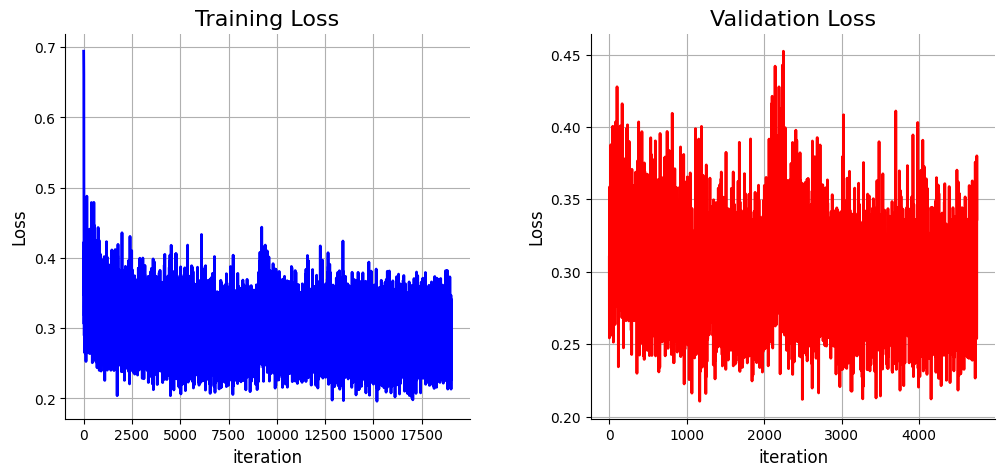

Best loss for this fold is 0.2971
Now at fold 2:



  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [1/25]: Train loss: 0.3452, Valid loss: 0.3206
Saving model with loss 0.3206


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [2/25]: Train loss: 0.3312, Valid loss: 0.3189
Saving model with loss 0.3189


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [3/25]: Train loss: 0.3247, Valid loss: 0.3147
Saving model with loss 0.3147


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [4/25]: Train loss: 0.3203, Valid loss: 0.3120
Saving model with loss 0.3120


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [5/25]: Train loss: 0.3166, Valid loss: 0.3087
Saving model with loss 0.3087


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [6/25]: Train loss: 0.3131, Valid loss: 0.3060
Saving model with loss 0.3060


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [7/25]: Train loss: 0.3102, Valid loss: 0.3036
Saving model with loss 0.3036


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [8/25]: Train loss: 0.3078, Valid loss: 0.3018
Saving model with loss 0.3018


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [9/25]: Train loss: 0.3058, Valid loss: 0.3004
Saving model with loss 0.3004


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [10/25]: Train loss: 0.3041, Valid loss: 0.2989
Saving model with loss 0.2989


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [11/25]: Train loss: 0.3026, Valid loss: 0.2978
Saving model with loss 0.2978


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [12/25]: Train loss: 0.3014, Valid loss: 0.2970
Saving model with loss 0.2970


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [13/25]: Train loss: 0.3003, Valid loss: 0.2961
Saving model with loss 0.2961


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [14/25]: Train loss: 0.2994, Valid loss: 0.2953
Saving model with loss 0.2953


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [15/25]: Train loss: 0.2985, Valid loss: 0.2946
Saving model with loss 0.2946


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [16/25]: Train loss: 0.2977, Valid loss: 0.2940
Saving model with loss 0.2940


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [17/25]: Train loss: 0.2969, Valid loss: 0.2935
Saving model with loss 0.2935


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [18/25]: Train loss: 0.2961, Valid loss: 0.2930
Saving model with loss 0.2930


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [19/25]: Train loss: 0.2955, Valid loss: 0.2926
Saving model with loss 0.2926


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [20/25]: Train loss: 0.2949, Valid loss: 0.2922
Saving model with loss 0.2922


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [21/25]: Train loss: 0.2944, Valid loss: 0.2919
Saving model with loss 0.2919


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [22/25]: Train loss: 0.2938, Valid loss: 0.2916
Saving model with loss 0.2916


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [23/25]: Train loss: 0.2933, Valid loss: 0.2913
Saving model with loss 0.2913


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [24/25]: Train loss: 0.2927, Valid loss: 0.2910
Saving model with loss 0.2910


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [25/25]: Train loss: 0.2922, Valid loss: 0.2908
Saving model with loss 0.2908


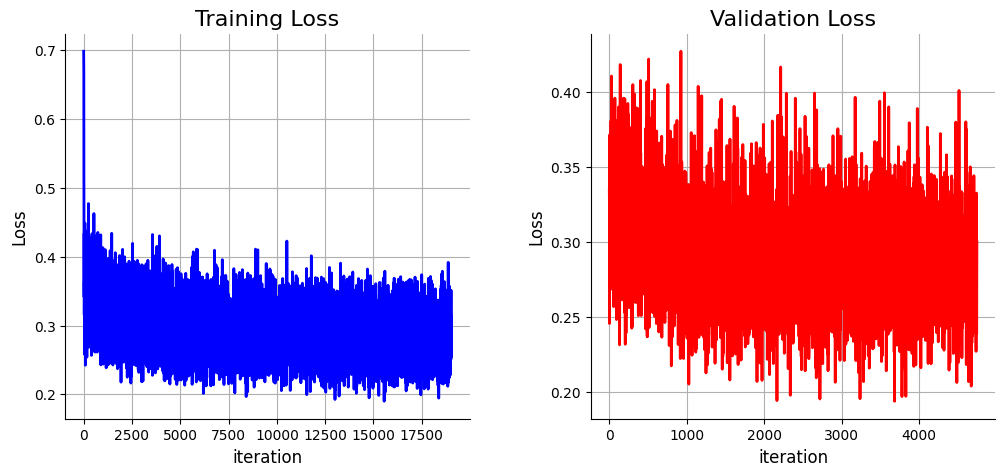

Best loss for this fold is 0.2908
Now at fold 3:



  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [1/25]: Train loss: 0.3401, Valid loss: 0.3169
Saving model with loss 0.3169


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [2/25]: Train loss: 0.3280, Valid loss: 0.3160
Saving model with loss 0.3160


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [3/25]: Train loss: 0.3225, Valid loss: 0.3141
Saving model with loss 0.3141


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [4/25]: Train loss: 0.3185, Valid loss: 0.3122
Saving model with loss 0.3122


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [5/25]: Train loss: 0.3154, Valid loss: 0.3097
Saving model with loss 0.3097


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [6/25]: Train loss: 0.3123, Valid loss: 0.3074
Saving model with loss 0.3074


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [7/25]: Train loss: 0.3097, Valid loss: 0.3053
Saving model with loss 0.3053


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [8/25]: Train loss: 0.3074, Valid loss: 0.3036
Saving model with loss 0.3036


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [9/25]: Train loss: 0.3055, Valid loss: 0.3023
Saving model with loss 0.3023


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [10/25]: Train loss: 0.3038, Valid loss: 0.3010
Saving model with loss 0.3010


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [11/25]: Train loss: 0.3024, Valid loss: 0.2999
Saving model with loss 0.2999


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [12/25]: Train loss: 0.3011, Valid loss: 0.2990
Saving model with loss 0.2990


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [13/25]: Train loss: 0.2999, Valid loss: 0.2982
Saving model with loss 0.2982


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [14/25]: Train loss: 0.2989, Valid loss: 0.2975
Saving model with loss 0.2975


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [15/25]: Train loss: 0.2979, Valid loss: 0.2968
Saving model with loss 0.2968


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [16/25]: Train loss: 0.2971, Valid loss: 0.2963
Saving model with loss 0.2963


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [17/25]: Train loss: 0.2963, Valid loss: 0.2958
Saving model with loss 0.2958


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [18/25]: Train loss: 0.2956, Valid loss: 0.2954
Saving model with loss 0.2954


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [19/25]: Train loss: 0.2949, Valid loss: 0.2950
Saving model with loss 0.2950


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [20/25]: Train loss: 0.2942, Valid loss: 0.2946
Saving model with loss 0.2946


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [21/25]: Train loss: 0.2936, Valid loss: 0.2943
Saving model with loss 0.2943


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [22/25]: Train loss: 0.2930, Valid loss: 0.2941
Saving model with loss 0.2941


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [23/25]: Train loss: 0.2924, Valid loss: 0.2938
Saving model with loss 0.2938


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [24/25]: Train loss: 0.2919, Valid loss: 0.2936
Saving model with loss 0.2936


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [25/25]: Train loss: 0.2913, Valid loss: 0.2934
Saving model with loss 0.2934


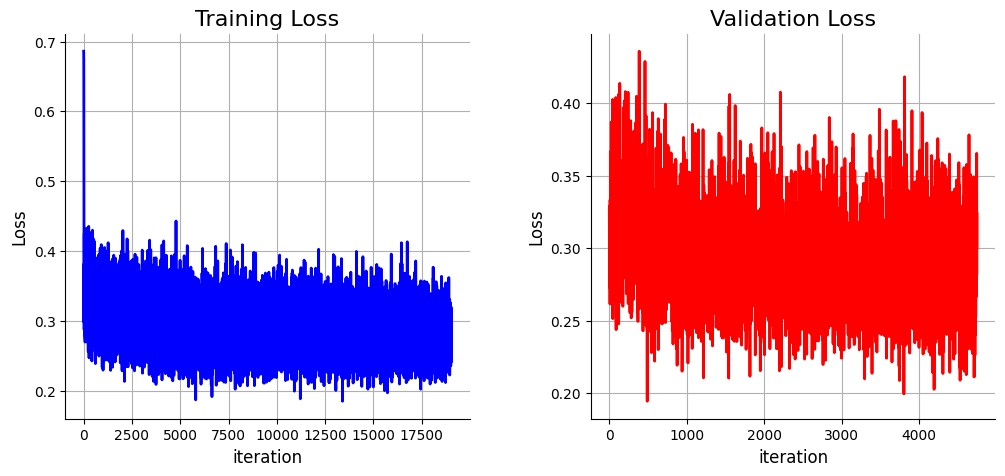

Best loss for this fold is 0.2934
Now at fold 4:



  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [1/25]: Train loss: 0.3438, Valid loss: 0.3254
Saving model with loss 0.3254


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [2/25]: Train loss: 0.3305, Valid loss: 0.3181
Saving model with loss 0.3181


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [3/25]: Train loss: 0.3253, Valid loss: 0.3156
Saving model with loss 0.3156


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [4/25]: Train loss: 0.3215, Valid loss: 0.3133
Saving model with loss 0.3133


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [5/25]: Train loss: 0.3185, Valid loss: 0.3116
Saving model with loss 0.3116


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [6/25]: Train loss: 0.3158, Valid loss: 0.3094
Saving model with loss 0.3094


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [7/25]: Train loss: 0.3132, Valid loss: 0.3068
Saving model with loss 0.3068


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [8/25]: Train loss: 0.3108, Valid loss: 0.3048
Saving model with loss 0.3048


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [9/25]: Train loss: 0.3088, Valid loss: 0.3029
Saving model with loss 0.3029


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [10/25]: Train loss: 0.3069, Valid loss: 0.3014
Saving model with loss 0.3014


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [11/25]: Train loss: 0.3053, Valid loss: 0.3001
Saving model with loss 0.3001


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [12/25]: Train loss: 0.3039, Valid loss: 0.2989
Saving model with loss 0.2989


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [13/25]: Train loss: 0.3026, Valid loss: 0.2980
Saving model with loss 0.2980


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [14/25]: Train loss: 0.3015, Valid loss: 0.2971
Saving model with loss 0.2971


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [15/25]: Train loss: 0.3005, Valid loss: 0.2963
Saving model with loss 0.2963


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [16/25]: Train loss: 0.2996, Valid loss: 0.2956
Saving model with loss 0.2956


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [17/25]: Train loss: 0.2987, Valid loss: 0.2949
Saving model with loss 0.2949


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [18/25]: Train loss: 0.2980, Valid loss: 0.2944
Saving model with loss 0.2944


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [19/25]: Train loss: 0.2973, Valid loss: 0.2939
Saving model with loss 0.2939


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [20/25]: Train loss: 0.2967, Valid loss: 0.2935
Saving model with loss 0.2935


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [21/25]: Train loss: 0.2961, Valid loss: 0.2930
Saving model with loss 0.2930


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [22/25]: Train loss: 0.2955, Valid loss: 0.2927
Saving model with loss 0.2927


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [23/25]: Train loss: 0.2949, Valid loss: 0.2923
Saving model with loss 0.2923


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [24/25]: Train loss: 0.2943, Valid loss: 0.2920
Saving model with loss 0.2920


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [25/25]: Train loss: 0.2937, Valid loss: 0.2917
Saving model with loss 0.2917


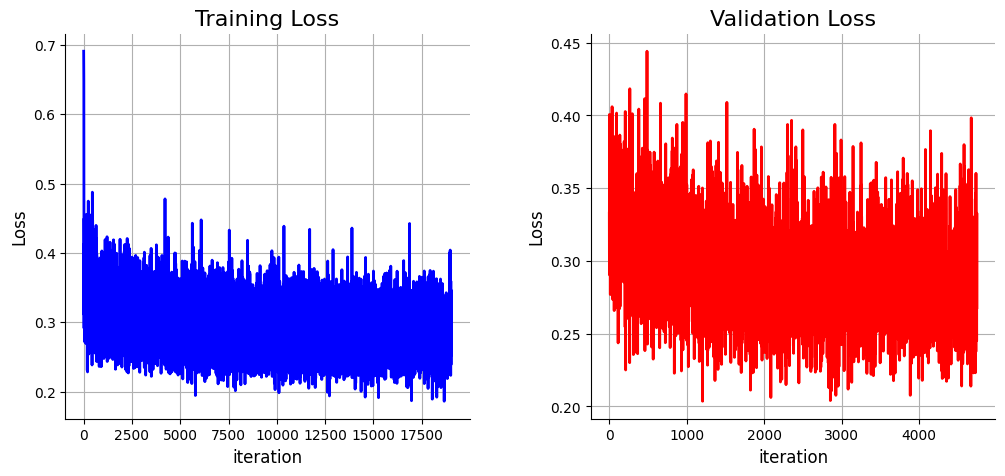

Best loss for this fold is 0.2917
Now at fold 5:



  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [1/25]: Train loss: 0.3380, Valid loss: 0.3192
Saving model with loss 0.3192


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [2/25]: Train loss: 0.3270, Valid loss: 0.3177
Saving model with loss 0.3177


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [3/25]: Train loss: 0.3219, Valid loss: 0.3144
Saving model with loss 0.3144


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [4/25]: Train loss: 0.3174, Valid loss: 0.3117
Saving model with loss 0.3117


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [5/25]: Train loss: 0.3133, Valid loss: 0.3090
Saving model with loss 0.3090


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [6/25]: Train loss: 0.3102, Valid loss: 0.3068
Saving model with loss 0.3068


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [7/25]: Train loss: 0.3075, Valid loss: 0.3048
Saving model with loss 0.3048


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [8/25]: Train loss: 0.3053, Valid loss: 0.3030
Saving model with loss 0.3030


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [9/25]: Train loss: 0.3033, Valid loss: 0.3015
Saving model with loss 0.3015


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [10/25]: Train loss: 0.3017, Valid loss: 0.3003
Saving model with loss 0.3003


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [11/25]: Train loss: 0.3003, Valid loss: 0.2993
Saving model with loss 0.2993


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [12/25]: Train loss: 0.2990, Valid loss: 0.2985
Saving model with loss 0.2985


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [13/25]: Train loss: 0.2979, Valid loss: 0.2977
Saving model with loss 0.2977


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [14/25]: Train loss: 0.2969, Valid loss: 0.2971
Saving model with loss 0.2971


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [15/25]: Train loss: 0.2961, Valid loss: 0.2965
Saving model with loss 0.2965


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [16/25]: Train loss: 0.2953, Valid loss: 0.2960
Saving model with loss 0.2960


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [17/25]: Train loss: 0.2945, Valid loss: 0.2956
Saving model with loss 0.2956


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [18/25]: Train loss: 0.2938, Valid loss: 0.2952
Saving model with loss 0.2952


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [19/25]: Train loss: 0.2932, Valid loss: 0.2949
Saving model with loss 0.2949


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [20/25]: Train loss: 0.2925, Valid loss: 0.2946
Saving model with loss 0.2946


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [21/25]: Train loss: 0.2919, Valid loss: 0.2944
Saving model with loss 0.2944


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [22/25]: Train loss: 0.2913, Valid loss: 0.2942
Saving model with loss 0.2942


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [23/25]: Train loss: 0.2908, Valid loss: 0.2940
Saving model with loss 0.2940


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [24/25]: Train loss: 0.2902, Valid loss: 0.2939
Saving model with loss 0.2939


  0%|          | 0/761 [00:00<?, ?it/s]

Epoch [25/25]: Train loss: 0.2896, Valid loss: 0.2938
Saving model with loss 0.2938


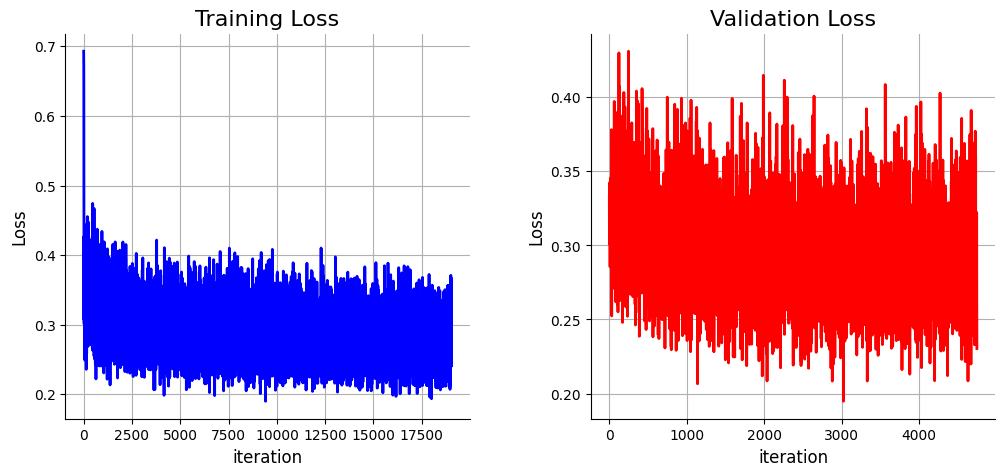

Best loss for this fold is 0.2938


In [12]:
dataset_train = TrainDataset('./share_data/feature/0603_4+1/train_5.npy', './share_data/finaldura33-22/train_duration_target.npy')
dataset_test = TestDataset('./share_data/feature/0603_4+1/test_5.npy')

batch_size = config['batch_size'] #符合test loader的因數
valid_ratio = config['valid_ratio']
num_epoch = config['n_epochs']

kfold = KFold(n_splits=5)
test_loader = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, drop_last=False)

for fold_i, (train_ids, valid_ids) in enumerate(kfold.split(dataset_train)):
  model = SimpleLSTM().to(device)
  # Sample elements from selected ids
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  valid_sampler = torch.utils.data.SubsetRandomSampler(valid_ids)
  # Use sampler to select data for training and validation
  train_loader = DataLoader(dataset_train ,batch_size=batch_size, drop_last=True, sampler=train_sampler)
  valid_loader = DataLoader(dataset_train, batch_size=batch_size, drop_last=True, sampler=valid_sampler)
  print(f"Now at fold {fold_i+1}:\n")
  train(train_loader, valid_loader, model, "SimpleLSTM", epochs_num = num_epoch, fold_i = fold_i)

In [ ]:
for _, (data, labels) in enumerate(train_loader):
  print(data.shape, labels.shape) #train:1036 columns, test:28 columns 
  break; ## seqlen根据数据特征数量调整，1036/28 = 37

## 產生輸出

In [13]:
model = SimpleLSTM().to(device)
model.load_state_dict(torch.load('./share_data/model_weights/LSTM_2.ckpt'))
model.eval()
output_list = []
with torch.no_grad():
  for datas in test_loader:
    datas = datas.to(device) 
    output_list.append(model(datas).cpu())

In [14]:
flatten_data = np.concatenate(output_list, axis=0)
showans = pd.DataFrame(flatten_data)

In [17]:
sample = pd.read_csv("./data/sample.csv")
answer = sample
for i in range(1,29):
    answer.iloc[:,i] = showans.iloc[:, i-1]
display(answer)

<ipython-input-17-20a01fd229e5>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  answer.iloc[:,i] = showans.iloc[:, i-1]


,user_id,time_slot_0,time_slot_1,time_slot_2,time_slot_3,time_slot_4,time_slot_5,time_slot_6,time_slot_7,time_slot_8,...,time_slot_18,time_slot_19,time_slot_20,time_slot_21,time_slot_22,time_slot_23,time_slot_24,time_slot_25,time_slot_26,time_slot_27
0,30460,0.093822,0.049213,0.008251,0.425546,0.077350,0.053453,0.011308,0.417536,0.038431,...,0.004231,0.405854,0.032615,0.043537,0.003391,0.331393,0.039157,0.047213,0.005374,0.150971
1,30461,0.289966,0.582096,0.014592,0.018083,0.307765,0.564940,0.002321,0.001654,0.016714,...,0.001519,0.001329,0.013862,0.489476,0.001894,0.002166,0.024896,0.354575,0.008592,0.008336
2,30462,0.197982,0.295367,0.023346,0.059832,0.246931,0.306615,0.018243,0.062390,0.231717,...,0.014312,0.049252,0.184657,0.259612,0.012948,0.050484,0.178933,0.212557,0.017861,0.029308
3,30463,0.033682,0.018544,0.003330,0.001876,0.047753,0.028539,0.002405,0.000786,0.163671,...,0.001798,0.001425,0.197513,0.060314,0.003980,0.001946,0.236999,0.048133,0.005896,0.002209
4,30464,0.061353,0.088124,0.021225,0.012445,0.094562,0.159883,0.017989,0.012453,0.184106,...,0.010725,0.007191,0.103218,0.109259,0.012700,0.005923,0.086509,0.109353,0.012823,0.005007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,38071,0.094883,0.155024,0.026616,0.063195,0.156970,0.162049,0.014412,0.039074,0.075796,...,0.012493,0.030440,0.064417,0.108971,0.012921,0.041764,0.081528,0.096032,0.019321,0.047374
7612,38072,0.554548,0.604026,0.077854,0.103194,0.456347,0.424080,0.013806,0.026280,0.223877,...,0.006818,0.012426,0.091512,0.118990,0.007391,0.008856,0.101678,0.094008,0.006814,0.009172
7613,38073,0.573276,0.660147,0.114716,0.126993,0.495251,0.482774,0.025461,0.038808,0.240017,...,0.013383,0.017300,0.107506,0.169265,0.013323,0.014135,0.118049,0.130203,0.013297,0.014453
7614,38074,0.060241,0.124091,0.038313,0.025309,0.104707,0.144698,0.025999,0.019976,0.078565,...,0.027083,0.021690,0.078951,0.133621,0.032647,0.033699,0.096820,0.114996,0.036693,0.028560


In [18]:
answer.to_csv("submit.csv", index=False)

In [ ]:
summary(model)